In [1]:
import numpy as np
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print('Pytorch version:[%s].'%(torch.__version__))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('[%s].'%(device))

Pytorch version:[1.13.0].
[cuda:0].


## Set hyper parameter

In [2]:
EPOCHS = 300
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

## Prepare dataset

In [3]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                    #    transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), # 정규화 결과가 0 ~ 1
                                       transforms.Resize((227, 227)),
                                       transforms.RandomErasing(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

                                    #   transforms.CenterCrop(224),
val_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((227, 227)), 
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((227, 227)),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])


DATASET_PATH = './data'
train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(DATASET_PATH + '/val', transform=val_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
val_iter = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print('preparing dataset Done')

preparing dataset Done


In [4]:
train_labels_map = {v:k for k, v in train_data.class_to_idx.items()}
test_labels_map = {v:k for k, v in test_data.class_to_idx.items()}

In [5]:
data_iter = iter(test_iter)
# next(data_iter)
images, labels = next(data_iter)

In [6]:
images[0].shape

torch.Size([3, 227, 227])

## our model

In [7]:
class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super(AlexNet, self).__init__()
        self.n_classes = n_classes

        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), 

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 256 x 13 x 13)

            nn.Conv2d(256, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, 1, 1), # (b x 256 x 13 x 13)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2), # (b x 256 x 6 x 6)
        )
        
        self.classifer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=self.n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # x = torch.flatten(x, 1)
        x = x.view(-1, 6*6*256)
        x = self.classifer(x)
        return x

    # def test(self):
    #     net = LeNet(self.n_classes)
    #     x = torch.randn(1, 3, 224, 224)
    #     y = net(x)
    #     print(y.size())

        
        

### train

In [8]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

### evaluate

In [9]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(device), target.to(device)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [10]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs):
    train_loss_ = []
    val_loss_ = []

    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, train Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, val Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        train_loss_.append(round(train_loss, 5))
        val_loss_.append(round(val_loss, 5))
    model.load_state_dict(best_model_wts)  
    return model, train_loss_, val_loss_
 



In [11]:
len(train_labels_map)

119

In [12]:
import torchsummary

model = AlexNet(len(train_labels_map)).to(device)

# AlexNet의 Image 입력 사이즈는 (3, 227, 227) 입니다.
torchsummary.summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [46]:
import sys, os
__file__ = '/home/seongwoo/workspace/SLACK-util-test/model_noti/slack_handler/'
# sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/seongwoo/workspace/SLACK-util-test/model_noti'))))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(__file__))))
# from slack_handler

In [63]:
from slack_handler.slack_channel_noti import post_message
from slack_handler import config
from slack_handler.slack_channel_noti import post_file

In [15]:
model = AlexNet(len(train_labels_map)).to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

try:
    base, train_loss_list, val_loss_list = train_baseline(model, train_iter, val_iter, optimizer, EPOCHS)
    torch.save(base,'baseline.pt')
    
    train_loss_msg = train_loss_list[-5]
    val_loss_msg = val_loss_list[-5]
    
    for i in range(-4, 0):
        train_loss_msg += f' ---> {train_loss_list[i]}'
        val_loss_msg += f' ---> {val_loss_list[i]}'
    
    post_msg = f'학습이 완료되었습니다\ntrain loss : {train_loss_msg}\nval loss : {val_loss_msg}'
    
    res_ = post_message(config.token, config.channel_id, post_msg)

except Exception as e:
    res_ = post_message(config.token, config.channel_id, f'Error : {e}')



-------------- epoch 1 ----------------
train Loss: 4.6147, train Accuracy: 2.27%
val Loss: 4.6091, val Accuracy: 2.24%
Completed in 0m 30s
-------------- epoch 2 ----------------
train Loss: 4.4194, train Accuracy: 4.19%
val Loss: 4.3811, val Accuracy: 3.84%
Completed in 0m 29s
-------------- epoch 3 ----------------
train Loss: 4.3249, train Accuracy: 4.91%
val Loss: 4.3093, val Accuracy: 4.91%
Completed in 0m 29s
-------------- epoch 4 ----------------
train Loss: 4.1418, train Accuracy: 6.49%
val Loss: 4.1153, val Accuracy: 6.97%
Completed in 0m 29s
-------------- epoch 5 ----------------
train Loss: 4.0591, train Accuracy: 7.73%
val Loss: 4.0545, val Accuracy: 7.58%
Completed in 0m 29s
-------------- epoch 6 ----------------
train Loss: 3.9480, train Accuracy: 8.92%
val Loss: 3.9453, val Accuracy: 8.48%
Completed in 0m 29s
-------------- epoch 7 ----------------
train Loss: 3.8332, train Accuracy: 10.73%
val Loss: 3.8522, val Accuracy: 9.57%
Completed in 0m 29s
-------------- epoc

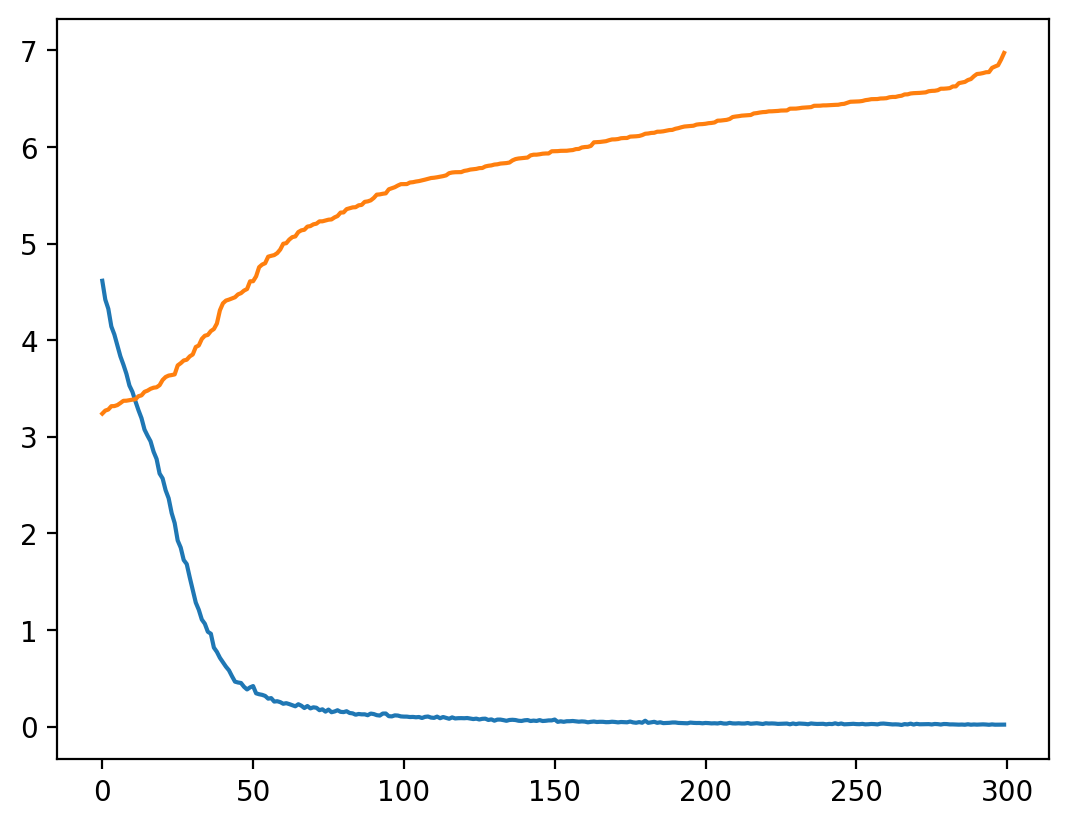

In [52]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.savefig('val_plot.png')


/tmp/tmpn68lm0vn/val_plot.png


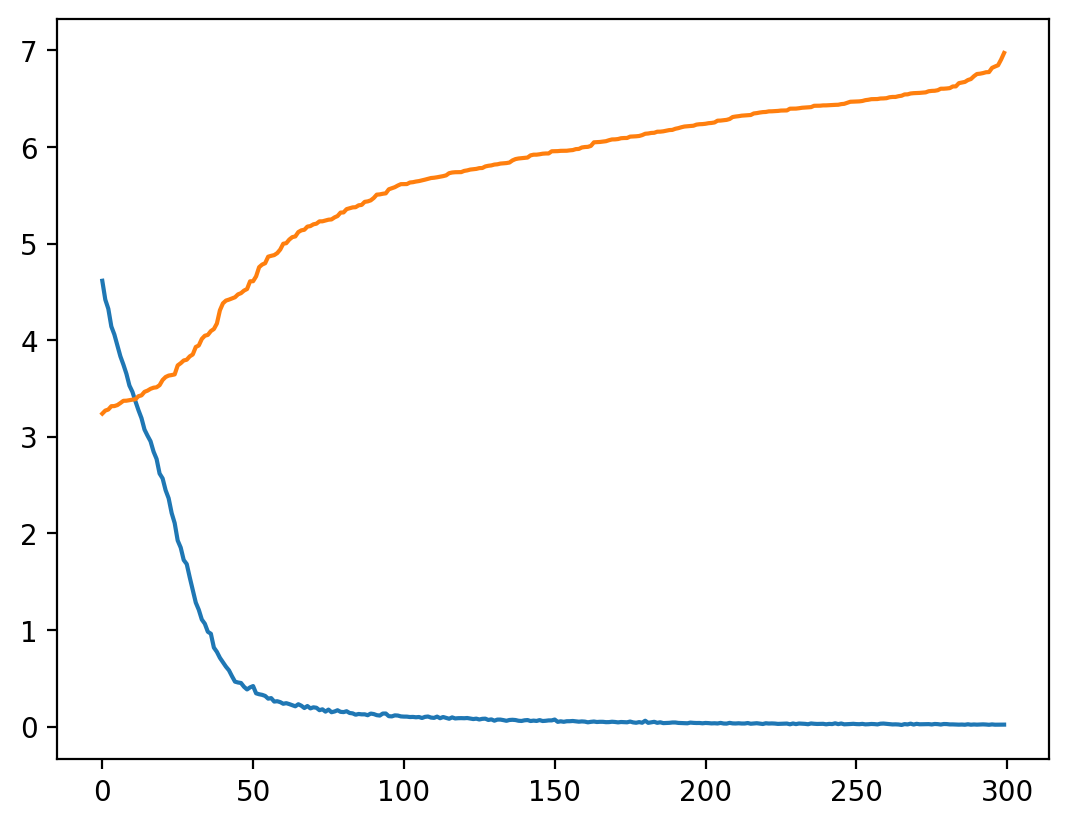

In [61]:
import os
import tempfile

with tempfile.TemporaryDirectory() as tempDir:
    if os.path.exists(tempDir):
        plt.plot(train_loss_list)
        plt.plot(val_loss_list)
        plt.savefig(f'{tempDir}/val_plot.png')
        with open(f'{tempDir}/val_plot.png', 'rb') as f:
            content = f.read()
            # print('temp dir: ', tempDir)
            post_message(config.token, config.channel_id, content)
            post_file(config.user_token, config.channel_id, f.name, content)
            print(f.name)